# Purpose
This project focuses on classifying asteroids as hazardous or not. The dataset was created from NASA data about asteroids classified as Near Earth Objects (NEOs) from 1910-2024. A collision between an asteroid and the Earth is dangerous and accurate predictions of which asteroids are potentially hazardous allows for emergency preparations. The purpose of this project is to use data collected about asteroids to develop a model to classify asteroids as hazardous or not and to identify which features are most predictive. 

# Dataset Description
 The dataset is available at [www.kaggle.com/datasets/ivansher](https://www.kaggle.com/datasets/ivansher/nasa-nearest-earth-objects-1910-2024/data). It was compiled from APIs available from [NASA](https://api.nasa.gov/). There are 338,199 observations and 9 features, including the classification label. The features are as follows:
 - neo_id: a unique identifier for each asteroid
 - name: NASA name for each asteroid
 - absolute_magnitude: standardized measure of luminosity
 - estimated_diameter_min: minimum estimated diameter of each asteroid in kilometers
 - estimated_diameter_max: maximum estimated diameter of each asteroid in kilometers
 - orbiting_body: planet around which the asteroid orbits
 - relative_velocity: asteroid's velocity relative to Earth's velocity in kilometers per hour
 - miss_distance: minimum distance between the Earth and asteroid during its orbit in kilometers
 - is_hazardous: a Boolean variable identifying whether the asteroid is considered hazardous

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import tree

In [2]:
#load data

df = pd.read_csv(r"C:\Users\mmull\OneDrive\Documents\MSDS\ML Supervised Project\archive\nearest-earth-objects(1910-2024).csv")
print('Shape: ', df.shape)
print('Features: ', df.columns)
df.dtypes

Shape:  (338199, 9)
Features:  Index(['neo_id', 'name', 'absolute_magnitude', 'estimated_diameter_min',
       'estimated_diameter_max', 'orbiting_body', 'relative_velocity',
       'miss_distance', 'is_hazardous'],
      dtype='object')


neo_id                      int64
name                       object
absolute_magnitude        float64
estimated_diameter_min    float64
estimated_diameter_max    float64
orbiting_body              object
relative_velocity         float64
miss_distance             float64
is_hazardous                 bool
dtype: object

# Data Cleaning
## Drop columns
Because the dataset focuses on NEOs, all objects are likely to orbit the Earth, which means orbiting_body would add no useful information to the project. After converting the datatype to category and identifying the unique values, that assumption is verified. Therefore, orbiting_body is dropped from the dataset.
Based on the heatmap, estimated_diameter_max and estimated_diameter_min are perfectly correlated. It is redundant to include both features in the model. Estimated_diameter_max was chosen to be dropped because keeping the minimum value is more conservative.
## Impute null values
Next, the null values were identified. Three features had null values. Because the number of missing values is small (28 for each feature), imputing those values is the most appropriate strategy. In order to choose the most appropriate value to impute for the missing data, histograms were created for each feature. Because absolute_magnitude has a normal distribution, its missing values were replaced with its mean. Because estimated_diameter_max and estimated_diameter_min were not normally distributed, their missing values were replaced with their respective medians.
## Outliers
Several asteroids have estimated diameters that are significantly greater than the mean. However, these measurements are unlikely to be errors and eliminated them from the dataset would eliminate information about the subset of larger NEOs.
## Conclusion
The cleaned dataset maintained all observations and 7 features. The cleaned dataset retains the important information necessary to build a model while eliminating redundant or missing information. The remaining features are:
- neo_id
- name
- absolute_magnitude
- estimated_diameter_min
- relative_velocity
- miss_distance
- is_hazardous


In [3]:
#convert orbiting_body to category datatype

df = df.astype({'orbiting_body': 'category'})

#check for unique values
df['orbiting_body'].unique()


['Earth']
Categories (1, object): ['Earth']

In [4]:
#one only value in orbiting_body, so drop column

df = df.drop(columns = 'orbiting_body')

In [5]:
#check for null values

pd.isnull(df).sum()

neo_id                     0
name                       0
absolute_magnitude        28
estimated_diameter_min    28
estimated_diameter_max    28
relative_velocity          0
miss_distance              0
is_hazardous               0
dtype: int64

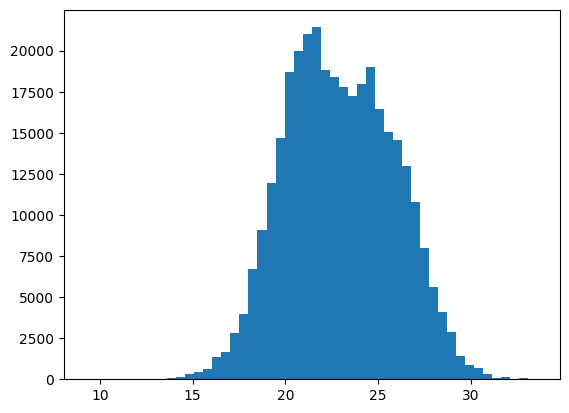

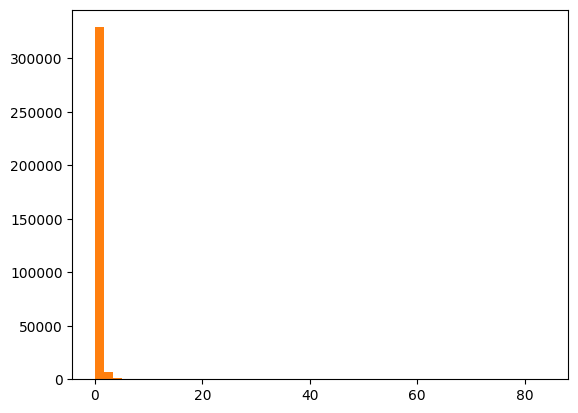

In [6]:
#impute missing values


#histograms to see distributions
plt.hist(df['absolute_magnitude'], bins = 50)
plt.show()
plt.hist(df['estimated_diameter_min'], bins = 50)
plt.hist(df['estimated_diameter_max'], bins = 50)

#impute
df['absolute_magnitude'] = df['absolute_magnitude'].fillna(np.nanmean(df['absolute_magnitude']))
df['estimated_diameter_min'] = df['estimated_diameter_min'].fillna(np.nanmedian(df['estimated_diameter_min']))
df['estimated_diameter_max'] = df['estimated_diameter_max'].fillna(np.nanmedian(df['estimated_diameter_max']))

In [7]:
pd.isnull(df).sum()

neo_id                    0
name                      0
absolute_magnitude        0
estimated_diameter_min    0
estimated_diameter_max    0
relative_velocity         0
miss_distance             0
is_hazardous              0
dtype: int64

In [8]:
df.describe()

,neo_id,absolute_magnitude,estimated_diameter_min,estimated_diameter_max,relative_velocity,miss_distance
count,3.381990e+05,338199.000000,338199.000000,338199.000000,338199.000000,3.381990e+05
mean,1.759939e+07,22.932525,0.157805,0.352863,51060.662908,4.153535e+07
std,2.287225e+07,2.911096,0.313873,0.701842,26399.238435,2.077399e+07
min,2.000433e+06,9.250000,0.000511,0.001143,203.346433,6.745533e+03
25%,3.373980e+06,20.740000,0.025384,0.056760,30712.031471,2.494540e+07
50%,3.742127e+06,22.800000,0.073207,0.163697,47560.465474,4.332674e+07
75%,5.405374e+07,25.100000,0.189041,0.422708,66673.820614,5.933961e+07
max,5.446281e+07,33.580000,37.545248,83.953727,291781.106613,7.479865e+07


In [9]:
#check whether max values are outliers or errors

sorted = df.sort_values('estimated_diameter_min', axis = 0, ascending = False)
sorted.head(n=20)

,neo_id,name,absolute_magnitude,estimated_diameter_min,estimated_diameter_max,relative_velocity,miss_distance,is_hazardous
34995,2001036,1036 Ganymed (A924 UB),9.25,37.545248,83.953727,69706.339208,7.424165e+07,False
279462,2001036,1036 Ganymed (A924 UB),9.25,37.545248,83.953727,51496.925534,5.372123e+07,False
4206,2001036,1036 Ganymed (A924 UB),9.25,37.545248,83.953727,61537.325800,5.705108e+07,False
169174,2000433,433 Eros (A898 PA),10.41,22.006703,49.208483,20971.107660,2.260935e+07,False
129823,2000433,433 Eros (A898 PA),10.41,22.006703,49.208483,13348.211214,6.619588e+07,False
189671,2000433,433 Eros (A898 PA),10.41,22.006703,49.208483,20394.978645,4.614935e+07,False
302952,2000433,433 Eros (A898 PA),10.41,22.006703,49.208483,21761.703426,3.120592e+07,False
85804,2000433,433 Eros (A898 PA),10.41,22.006703,49.208483,13053.955090,6.028930e+07,False
68087,2000433,433 Eros (A898 PA),10.41,22.006703,49.208483,21902.588656,3.216433e+07,False
209898,2000433,433 Eros (A898 PA),10.41,22.006703,49.208483,15501.247697,6.995798e+07,False


# EDA
## Feature associations
As noted above, the heatmap shows a perfect correlation between estimated_diameter_min and estimated_diameter_max. In addition, there is a moderate negative correlation (-0.59) between absolute_magnitude and estimated_diameter_min (and estimated_diameter_max). There is also a weak negative correlation (-0.35) between absolute_magnitude and relative_velocity. Finally, there is a weak positive correlation (0.32) between miss_distance and relative_velocity. In order to better visualize these relationships, a pairplot was used.
The pairplot shows a clear nonlinear negative relationship between absolute_magnitude and estimated_diameter_min. The other plots show little evidence of association.
## Bar and box plots
The bar chart shows the distribution of 'is_hazardous.' 295,037 observations (87.2%) are not hazardous and 43162 (12.8%) are. The box plots compare the distributions of observations that are and are not hazardous for each feature. Is_hazardous does not affect the distribution of miss_distance. For relative_velocity, the interquartile range sits slightly higher for hazardous observations. For estimated_diameter_min, removing outliers from the plot was necessary to see interquartile ranges. Again, the interquartile range is higher for hazardous observations. For absolute_magnitude, the interquartile range is lower for hazardous observations.
## Conclusions
Overall, an NEO is much more likely to be nonhazardous. Model selection and evaluation will need to compensate for the imbalance in the dataset. Initial EDA suggests that hazardous NEOs on average have higher relative_velocity and estimated_diameter_min and lower absolute_magnitude. The nonlinear negative relationship between absolute_magnitude and estimated_diameter_min provides more evidence of this inverse association between those features.

<Axes: >

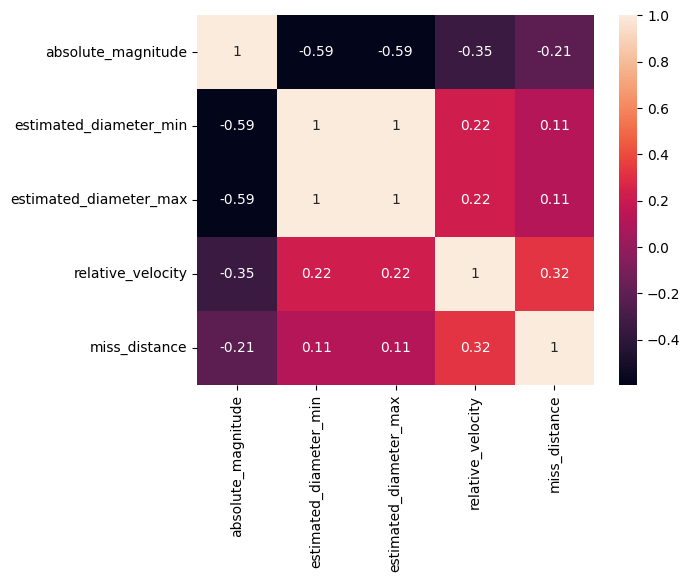

In [10]:
df_numeric = df[['absolute_magnitude', 'estimated_diameter_min', 'estimated_diameter_max', 'relative_velocity', 'miss_distance']]
corr = df_numeric.corr()
sns.heatmap(corr, annot = True)



In [11]:
#because there is a perfect correlation between min and max estimated_diameter, I will drop max
df = df.drop(columns = 'estimated_diameter_max')

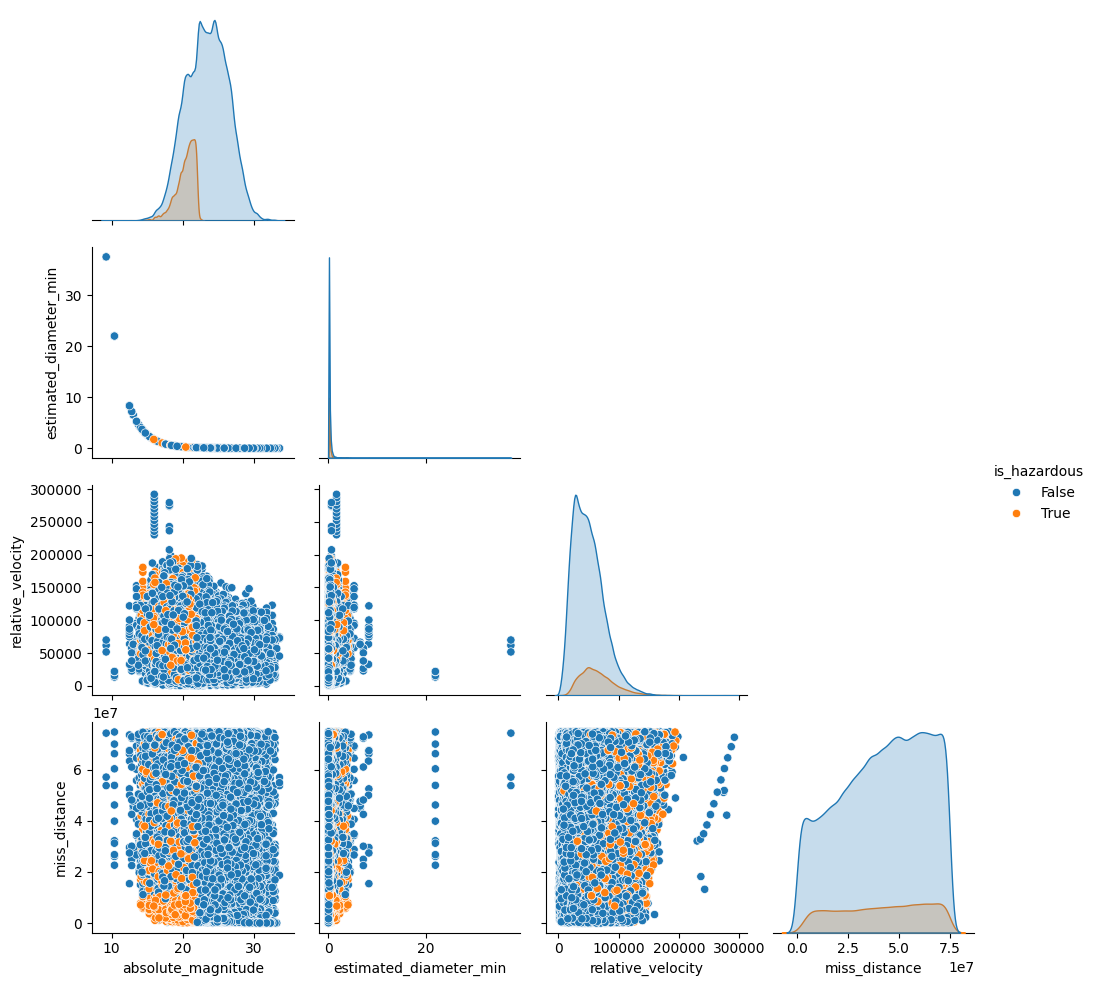

In [12]:

sns.pairplot(df, vars = ['absolute_magnitude', 'estimated_diameter_min', 'relative_velocity', 'miss_distance'], hue = 'is_hazardous',
            corner = True)

<Axes: xlabel='is_hazardous'>

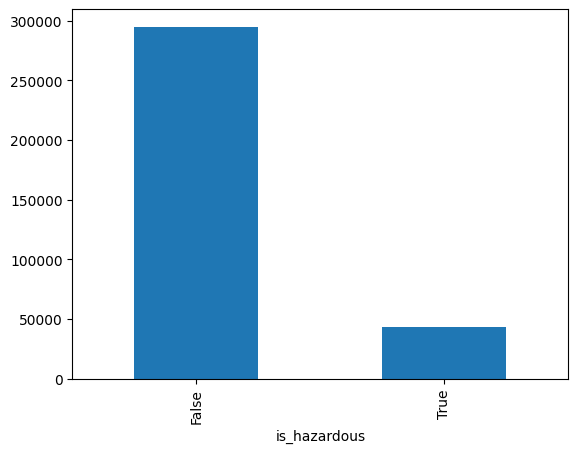

In [13]:
df['is_hazardous'].value_counts().plot(kind = 'bar')

In [14]:
df['is_hazardous'].value_counts()

is_hazardous
False    295037
True      43162
Name: count, dtype: int64

<Axes: xlabel='is_hazardous', ylabel='miss_distance'>

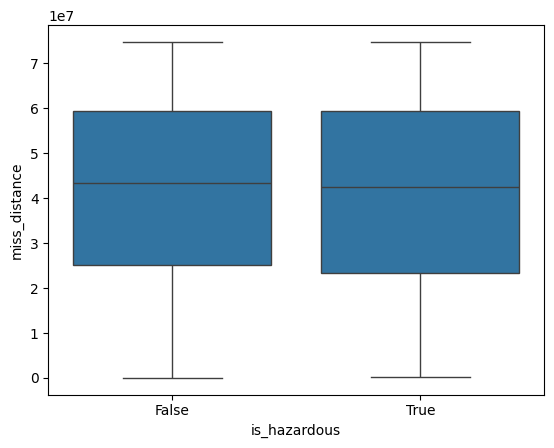

In [15]:
sns.boxplot(df, x = 'is_hazardous', y = 'miss_distance')

<Axes: xlabel='is_hazardous', ylabel='relative_velocity'>

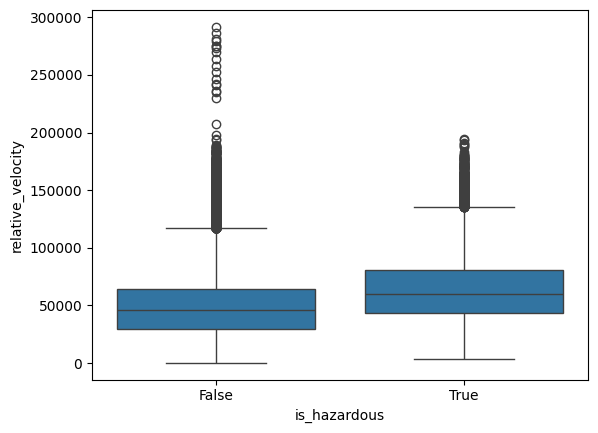

In [16]:
sns.boxplot(df, x = 'is_hazardous', y = 'relative_velocity')

<Axes: xlabel='is_hazardous', ylabel='estimated_diameter_min'>

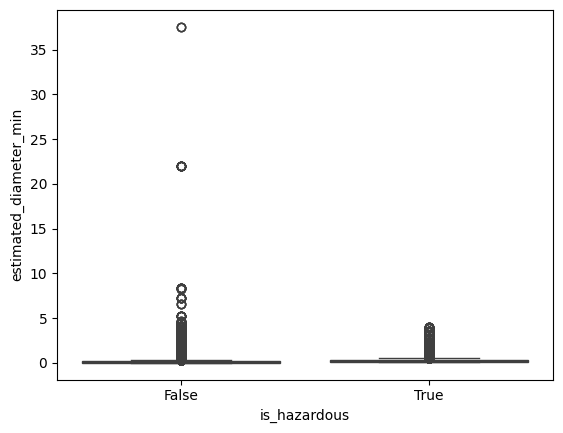

In [17]:
sns.boxplot(df, x = 'is_hazardous', y = 'estimated_diameter_min')

<Axes: xlabel='is_hazardous', ylabel='estimated_diameter_min'>

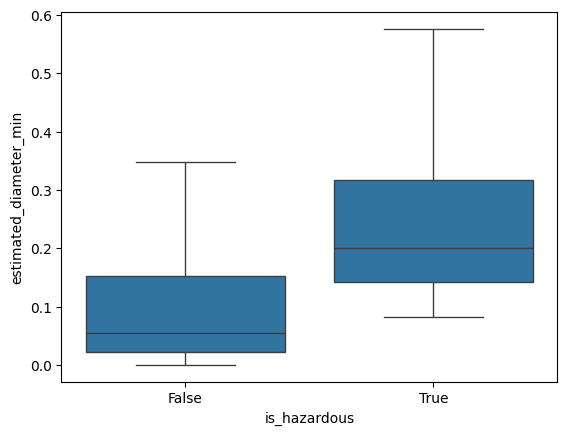

In [18]:
sns.boxplot(df, x = 'is_hazardous', y = 'estimated_diameter_min', showfliers = False)

<Axes: xlabel='is_hazardous', ylabel='absolute_magnitude'>

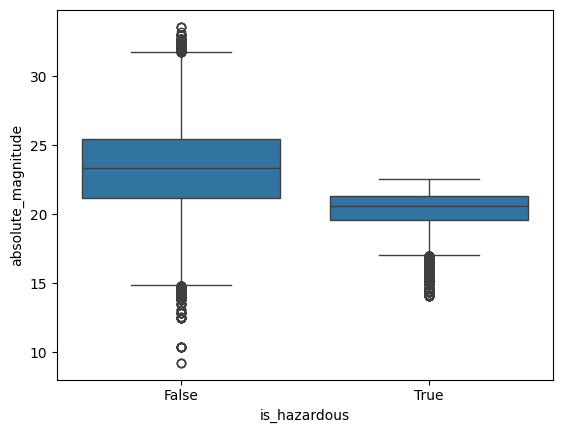

In [19]:
sns.boxplot(df, x = 'is_hazardous', y = 'absolute_magnitude')

# Models
The dataset is imbalanced, so included the stratify parameter when splitting the data in test and train sets to ensure the ratio of True and False values of 'is_hazardous' were equivilent between test and train sets. 
## Simple models
The main factors I used to select models were the binary classification target and imbalanced nature of the dataset.
The following simple models were selected:
- Logistic Regression Classifier - this model is commonly used for binary classification
- Decision Tree Classifier - this model is commonly used for classification and is easily interpretable
- Complement Naive Bayes Classifier - this model handles imbalanced datasets well
For each model, precision, recall, and f1 scores are calculated. In addition, two versions of the Decision Tree model were trained based on calculated feature importance.
## Ensemble model
The Decision Tree performed best among the simple models (see 'Results and Analysis' section for more detail). Therefore, I chose a random forest classifier as an ensemble model. As shown in the code below, I used grid search crossvalidation to fine-tune the hyperparameters to determine the final model.

In [20]:
x = df[['absolute_magnitude', 'relative_velocity', 'estimated_diameter_min', 'miss_distance']]
y = df['is_hazardous']
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(x, y, train_size = 0.8, random_state = 42, stratify = y)


In [21]:
#logistic regression

lrmodel = sklearn.linear_model.LogisticRegression(random_state = 0).fit(x_train, y_train)
predicted = lrmodel.predict(x_test)
conf_matrix = confusion_matrix(y_test, predicted)
conf_matrix


array([[58717,   291],
       [ 8466,   166]], dtype=int64)

In [22]:

print('Precision:', sklearn.metrics.precision_score(y_test, predicted))
print('Recall:', sklearn.metrics.recall_score(y_test, predicted))
print('F1:', sklearn.metrics.f1_score(y_test, predicted))

Precision: 0.36323851203501095
Recall: 0.019230769230769232
F1: 0.036527670810870286


In [23]:
#decision tree

dtmodel = DecisionTreeClassifier(random_state = 0, class_weight = {True: 8.7, False: 1.3}).fit(x_train, y_train)
predicted = dtmodel.predict(x_test)
conf_matrix = confusion_matrix(y_test, predicted)
conf_matrix

array([[55614,  3394],
       [ 3825,  4807]], dtype=int64)

In [24]:

print('Precision:', sklearn.metrics.precision_score(y_test, predicted))
print('Recall:', sklearn.metrics.recall_score(y_test, predicted))
print('F1:', sklearn.metrics.f1_score(y_test, predicted))
print('Feature Importance: ', dtmodel.feature_importances_)

Precision: 0.58614803072796
Recall: 0.5568813716404077
F1: 0.5711400225747044
Feature Importance:  [0.0814692  0.18094977 0.56769599 0.16988503]


In [25]:
# remove absolute_magnitude
dtmodel = DecisionTreeClassifier(random_state = 0, class_weight = {True: 8.7, False: 1.3}).fit(x_train[['miss_distance', 'relative_velocity', 'estimated_diameter_min']], y_train)
predicted = dtmodel.predict(x_test[['miss_distance', 'relative_velocity', 'estimated_diameter_min']])
conf_matrix = confusion_matrix(y_test, predicted)
conf_matrix

array([[55608,  3400],
       [ 3822,  4810]], dtype=int64)

In [26]:
print('Precision:', sklearn.metrics.precision_score(y_test, predicted))
print('Recall:', sklearn.metrics.recall_score(y_test, predicted))
print('F1:', sklearn.metrics.f1_score(y_test, predicted))
print('Feature Importance: ', dtmodel.feature_importances_)

Precision: 0.5858708891595615
Recall: 0.5572289156626506
F1: 0.5711910699441871
Feature Importance:  [0.17333361 0.18306343 0.64360296]


In [27]:
#Naive Bayes

nbmodel = ComplementNB(alpha = 100).fit(x_train, y_train)
predicted = nbmodel.predict(x_test)
conf_matrix = confusion_matrix(y_test, predicted)
conf_matrix

array([[35215, 23793],
       [ 3535,  5097]], dtype=int64)

In [28]:

print('Precision:', sklearn.metrics.precision_score(y_test, predicted))
print('Recall:', sklearn.metrics.recall_score(y_test, predicted))
print('F1:', sklearn.metrics.f1_score(y_test, predicted))

Precision: 0.17642782969885773
Recall: 0.5904772937905468
F1: 0.27168061403976335


In [29]:
# random forest

rfmodel = RandomForestClassifier(class_weight = {True: 8.7, False: 1.3}).fit(x_train, y_train)
predicted = rfmodel.predict(x_test)
conf_matrix = confusion_matrix(y_test, predicted)
conf_matrix

array([[57342,  1666],
       [ 4018,  4614]], dtype=int64)

In [30]:

print('Precision:', sklearn.metrics.precision_score(y_test, predicted))
print('Recall:', sklearn.metrics.recall_score(y_test, predicted))
print('F1:', sklearn.metrics.f1_score(y_test, predicted))
print('Feature Importance: ', rfmodel.feature_importances_)

Precision: 0.7347133757961783
Recall: 0.5345227062094532
F1: 0.6188304721030042
Feature Importance:  [0.24817967 0.18957346 0.39445586 0.167791  ]


In [34]:
# Fine tuning

param = {'criterion': ['gini', 'entropy', 'log_loss'], 'min_samples_leaf': range(1,16,5)}
best = GridSearchCV(RandomForestClassifier(class_weight = {True: 8.7, False: 1.3}), param_grid = param, cv = 3, scoring = 'f1')
best.fit(x_train, y_train)

GridSearchCV(cv=3,
             estimator=RandomForestClassifier(class_weight={False: 1.3,
                                                            True: 8.7}),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'min_samples_leaf': range(1, 16, 5)},
             scoring='f1')

In [35]:
print(best.best_params_)
print(best.best_score_)
predicted = best.predict(x_test)
print('Precision:', sklearn.metrics.precision_score(y_test, predicted))
print('Recall:', sklearn.metrics.recall_score(y_test, predicted))
print('F1:', sklearn.metrics.f1_score(y_test, predicted))

{'criterion': 'entropy', 'min_samples_leaf': 6}
0.614905370586029
Precision: 0.5183200579290369
Recall: 0.8292400370713624
F1: 0.6379110596203547


In [36]:
param = {'max_features': ['sqrt', 'log2', None], 'max_depth': [3, 9, None]}
best = GridSearchCV(RandomForestClassifier(criterion = 'entropy', class_weight = {True: 8.7, False: 1.3}, min_samples_leaf = 6), param_grid = param, cv = 3, scoring = 'f1')
best.fit(x_train, y_train)
    

GridSearchCV(cv=3,
             estimator=RandomForestClassifier(class_weight={False: 1.3,
                                                            True: 8.7},
                                              criterion='entropy',
                                              min_samples_leaf=6),
             param_grid={'max_depth': [3, 9, None],
                         'max_features': ['sqrt', 'log2', None]},
             scoring='f1')

In [37]:
print(best.best_params_)
print(best.best_score_)
predicted = best.predict(x_test)
print('Precision:', sklearn.metrics.precision_score(y_test, predicted))
print('Recall:', sklearn.metrics.recall_score(y_test, predicted))
print('F1:', sklearn.metrics.f1_score(y_test, predicted))

{'max_depth': None, 'max_features': 'log2'}
0.6136924953151485
Precision: 0.5160870508278504
Recall: 0.8269230769230769
F1: 0.6355339892267284


In [38]:
#fine tuned model
rfmodel = RandomForestClassifier(criterion = 'entropy', class_weight = {True: 8.7, False: 1.3}, min_samples_leaf = 6, max_features = 'log2').fit(x_train, y_train)
predicted = rfmodel.predict(x_test)
conf_matrix = confusion_matrix(y_test, predicted)
conf_matrix

print('Precision:', sklearn.metrics.precision_score(y_test, predicted))
print('Recall:', sklearn.metrics.recall_score(y_test, predicted))
print('F1:', sklearn.metrics.f1_score(y_test, predicted))
print('Feature Importance: ', rfmodel.feature_importances_)

Precision: 0.5159171298635674
Recall: 0.8279657089898054
F1: 0.6357126973537914
Feature Importance:  [0.28233118 0.14264512 0.44817963 0.12684407]


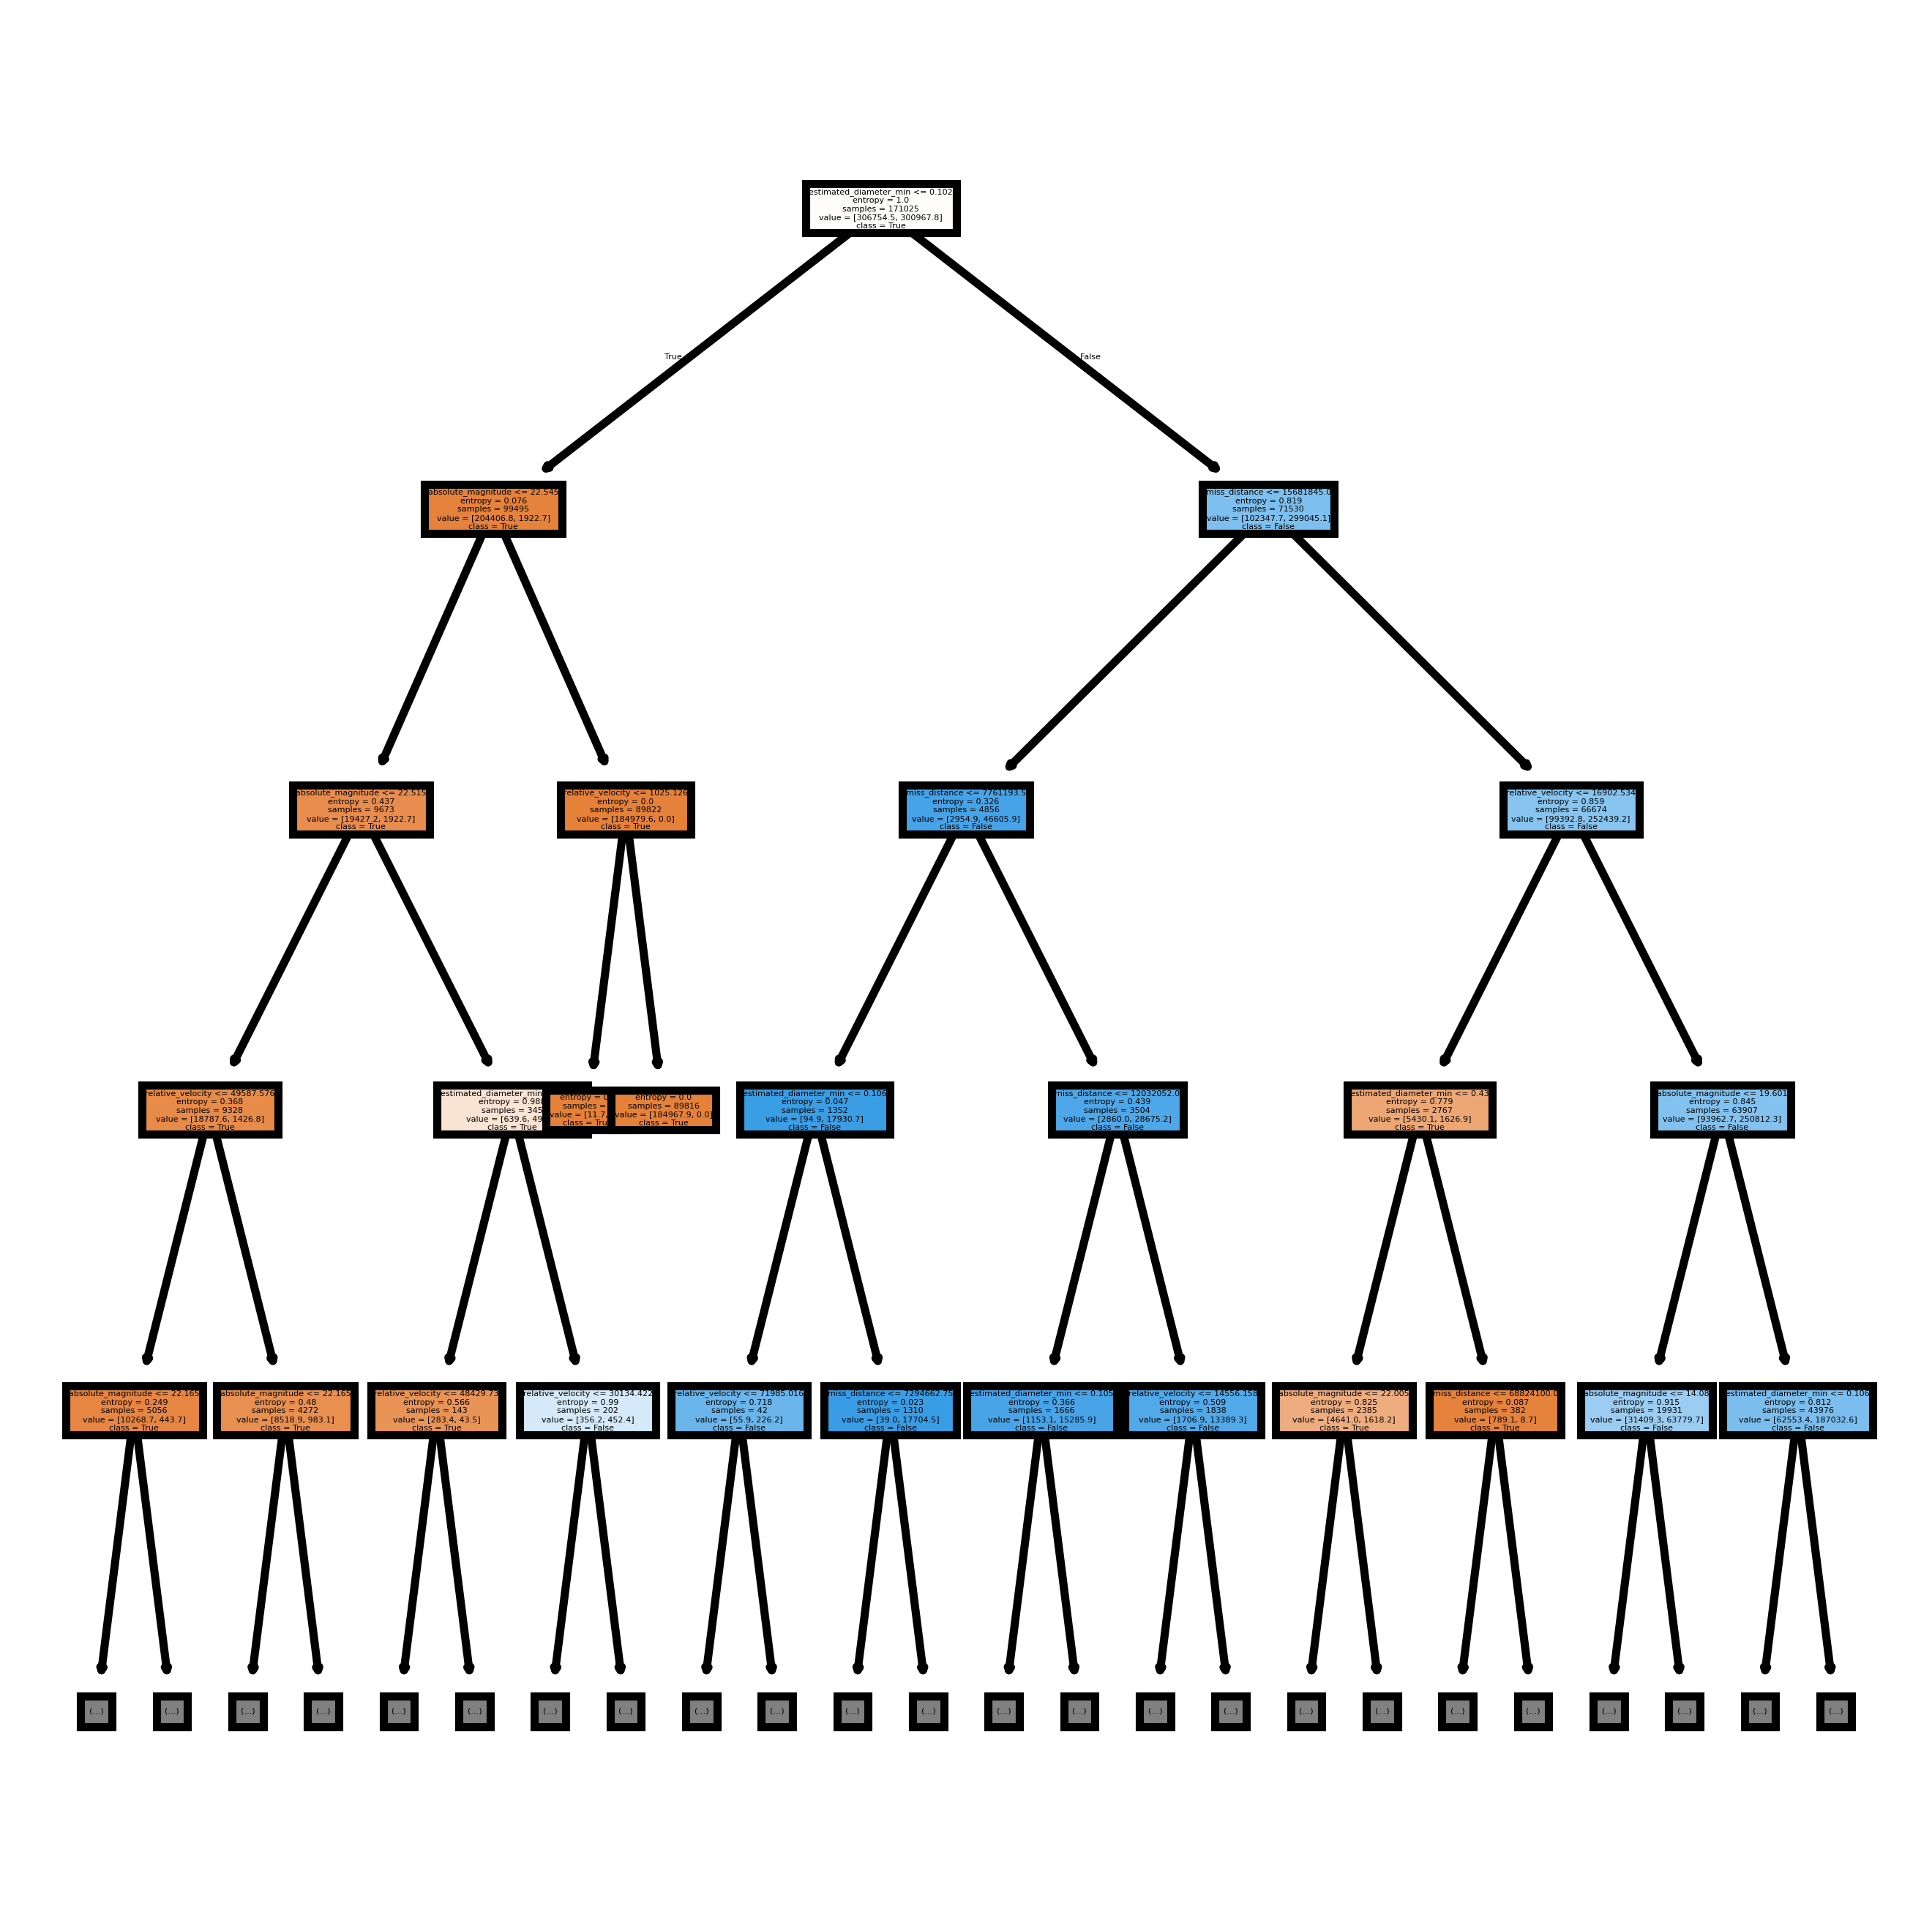

In [39]:
#visualize

fn=x_train.columns
cn=['True', 'False']
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800)
tree.plot_tree(rfmodel.estimators_[0], max_depth = 4,
               feature_names = fn, 
               class_names=cn,
               filled = True);
fig.savefig('rf_individualtree.png')

# Results and Analysis

| Model | Precision | Recall | F1 |
| --- | --- | --- | --- |
| Logistic Regression | 0.36 | 0.02 | 0.04 |
| Decision Tree | 0.59 | 0.56 | 0.57 |
| Complement Naive Bayes | 0.18 | 0.59 | 0.27 |
| Random Forest (initial) | 0.73 | 0.53 | 0.62 |
| Random Forest (final) | 0.52 | 0.83 | 0.64 |

## Evaluation strategy
The dataset is imbalanced, so accuracy is not a useful metric. It is more meaningful to correctly identify and classify the True values. For this reason, precision, recall, and f1 scores were used to evaluate the models. Ideally the final model would achieve high precision and recall, but recall will be prioritized because false negatives are more costly than false positives in this case. It is more dangerous to classify a hazardous asteroid as nonhazardous than to classify a nonhazardous asteroid as hazardous.
## Evaluation process
The initial logistic regression model performed poorly on both precision and recall, so I did not further pursue that model. Instead, I trained a simple decision tree. In order to address the imbalanced data, I set the class weight parameter to increase the weight of True values. As seen in the table above, this model performed significantly better than the logistic regression model. In analyzing the feature importance, 'absolute_magnitude' was least important, so I trained a second decision tree without that feature, but it did not perform significantly differently.
Next, a complement naive Bayes model was trained. This model is well-suited to imbalanced datasets. It did have a slightly higher recall score, but at the expense of a significantly lower precision score.<br>  
The decision tree model was the most effective of the three simple models, so I elected to use a random forest ensemble model. The initial model uses the class weight parameter to increase the weight of True values. As seen in the table above, it achieves the highest precision of all models and a similar recall to the decision tree and complement naive Bayes. I used grid search cross validation to finetune the hyperparameters for the optimal f1 score. This results in a higher recall and lower precision than the initial model. As stated in the 'Evaluation strategy' section, recall is prioritized for this dataset. Because this model achieves a significantly higher recall than other models, it is selected as the final model. Each feature has similar importance, so all were included in the final model.

# Discussion and Conclusion
The final model is able to correctly classify 82.8% of hazardous asteroids in the test set. The drawback of the model is the high rate of false positives.
## Takeaways
Based on the calculated feature importance of the final model, 'estimated_diameter_min' is the most significant factor in predicting whether an asteroid is hazardous, followed by 'absolute_magnitude'.  
## Improvements
The unbalanced nature of the dataset was a challenge for achieving an optimal classifier. There are several methods for oversampling the minority class that could be implemented to improve performance. For example, Synthetic Minority Oversample Technique (SMOTE) creates additional observations of the minority class that are similar to existing observations in that class. Another option is to remove observation in the majority class. Tomek Links is one method for doing so and removes observations in the majority class that have the lowest Euclidean distance from observations in the minority class.